In [9]:
from known_boundary.GP import optimise,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,Warped_TEI2_acquisition_opt

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import torch
import botorch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [16]:
fun = Powell(dim=4,negate=False)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = 10*dim
N = 6

fstar = 0.
fun = Trans_function(fun,fstar,min=True)

# GP+EI

In [17]:
BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            print('lengthscale is: ',np.sqrt(res[0])) 
            print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record)
            
    best_record = np.array(best_record)+fstar 
    BO_EI.append(best_record)

0
lengthscale is:  0.4129185128017211
variance is:  1.2929971608610429
lengthscale is:  0.3362438279518637
variance is:  1.0922699263535678
lengthscale is:  0.36770660763131613
variance is:  1.1782894381121771
lengthscale is:  0.4013976660918514
variance is:  1.3183694683592704
lengthscale is:  0.41292445321653004
variance is:  1.3626540241654208
lengthscale is:  0.4234164700654624
variance is:  1.4140342233881322
lengthscale is:  0.42725816337826494
variance is:  1.4369424202116363
lengthscale is:  0.3679204015600484
variance is:  1.1958042756649232
lengthscale is:  0.3531269439536882
variance is:  1.1502957970627803
lengthscale is:  0.3692234514290166
variance is:  1.2151680713477753
lengthscale is:  0.38413622639227935
variance is:  1.2873740684507524
lengthscale is:  0.35459765174417945
variance is:  1.1887937620901952
lengthscale is:  0.3510550419159156
variance is:  1.195431748463518
lengthscale is:  0.3615884721049561
variance is:  1.2454123759942195
lengthscale is:  0.336090929

# GP+MES

In [18]:
BO_MES = []

for exp in range(N):
    
    print(exp)

    seed = exp
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    fstar_mes = 0.
    

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):

            print(i)
            
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            
            fstar_standard = (fstar_mes - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            print('lengthscale is: ',np.sqrt(res[0])) 
            print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = MES_acquisition_opt(m,standard_bounds,fstar_standard)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())

            
    best_record = np.array(best_record)+fstar 
    BO_MES.append(best_record)

0
0
lengthscale is:  0.41291846702635465
variance is:  1.292997035150083
1
lengthscale is:  0.3634906988605002
variance is:  1.1620879076770882
2
lengthscale is:  0.4103662488422428
variance is:  1.3742150911983457
3
lengthscale is:  0.40385097716461416
variance is:  1.3257373929685157
4
lengthscale is:  0.410824221812044
variance is:  1.3659949069397865
5
lengthscale is:  0.44160645650796804
variance is:  1.558161843451395
6
lengthscale is:  0.4671491301452348
variance is:  1.750641321402765
7
lengthscale is:  0.4711032850813624
variance is:  1.783320201861878
8
lengthscale is:  0.4916892074692392
variance is:  1.9706129587807524
9
lengthscale is:  0.5144573790024509
variance is:  2.2147786367949642
10
lengthscale is:  0.533759171293857
variance is:  2.4511850375229254
11
lengthscale is:  0.5026551070697217
variance is:  2.2741974367194544
12
lengthscale is:  0.47766823988556634
variance is:  2.1157614612160023
13
lengthscale is:  0.47158745274730035
variance is:  2.1038598420895585
1

# log GP+TEI

In [19]:
Warped_BO_TEI2 = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            print(i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            print('lengthscale is: ', lengthscale)
            print('variance is: ',variance)
            print('c is: ',c)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_TEI2_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_TEI2.append(best_record)

0
0
lengthscale is:  0.2709906314685489
variance is:  1.9020481929657236
c is:  1e-05
81.28753364426164
1
lengthscale is:  0.24377476026399836
variance is:  2.2226747058270213
c is:  0.3
65.99808956206616
2
lengthscale is:  0.26967299541618756
variance is:  2.408260273560327
c is:  0.3
7.13461542750075
3
lengthscale is:  0.1768916051285589
variance is:  4.00125715500826
c is:  0.3
6.68480159282478
4
lengthscale is:  0.1494605427823169
variance is:  3.9788866463600923
c is:  0.3
6.68480159282478
5
lengthscale is:  0.1505636461541166
variance is:  4.275659611954089
c is:  0.3
6.68480159282478
6
lengthscale is:  0.12482549950364381
variance is:  4.471836988795422
c is:  0.3
6.68480159282478
7
lengthscale is:  0.1179747378631403
variance is:  4.818964711468732
c is:  0.3
0.9179156400490266
8
lengthscale is:  0.10347813508866599
variance is:  6.5669226942473005
c is:  0.3
0.9179156400490266
9
lengthscale is:  0.07091484507833885
variance is:  5.978227622068486
c is:  0.3
0.5167453803466266


# plot

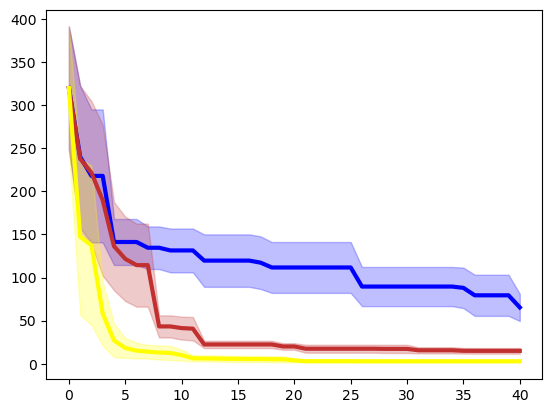

In [25]:
fstar = 0
N = 6

total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(BO_MES)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = (np.array(Warped_BO_TEI2)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

In [26]:
mean

array([319.98772414, 147.31089301, 137.50315942,  58.19623213,
        26.98158933,  18.3183926 ,  15.20037277,  13.99236315,
        13.0104389 ,  12.50865183,  10.03122061,   6.33753407,
         6.18041749,   6.0571365 ,   5.71801889,   5.64476312,
         5.45445215,   5.45445215,   5.21140141,   5.21140141,
         3.92301432,   2.9808598 ,   2.9808598 ,   2.9808598 ,
         2.9808598 ,   2.9808598 ,   2.90411537,   2.90411537,
         2.90411537,   2.90411537,   2.90411537,   2.90411537,
         2.90411537,   2.90411537,   2.90411537,   2.90411537,
         2.9029089 ,   2.9029089 ,   2.9029089 ,   2.9029089 ,
         2.9029089 ])